# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [1]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


Function for displaying one frame:

In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

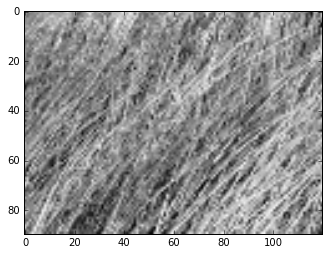

In [3]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Initialize all the parameters and normilize given sample:

In [4]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
sample_norm = (sample - sample_mean)/sample_std # normalization

print(sample_norm[0,:])

[-0.25717991 -0.05194427  0.31747988 ..., -0.54450981 -2.26848918
 -2.35058344]


Define combined kernel using GPy library:

In [5]:
import GPy

#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)
#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample_norm, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [6]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=100)

In [7]:
help(kernel)

Help on RBF in module GPy.kern.src.rbf object:

class RBF(GPy.kern.src.stationary.Stationary)
 |  Radial Basis Function kernel, aka squared-exponential, exponentiated quadratic or Gaussian kernel:
 |  
 |  .. math::
 |  
 |     k(r) = \sigma^2 \exp \bigg(- \frac{1}{2} r^2 \bigg)
 |  
 |  Method resolution order:
 |      RBF
 |      GPy.kern.src.stationary.Stationary
 |      GPy.kern.src.kern.Kern
 |      GPy.core.parameterization.parameterized.Parameterized
 |      paramz.parameterized.Parameterized
 |      GPy.core.parameterization.priorizable.Priorizable
 |      paramz.core.parameter_core.Parameterizable
 |      paramz.core.parameter_core.OptimizationHandlable
 |      paramz.core.constrainable.Constrainable
 |      paramz.core.indexable.Indexable
 |      paramz.core.nameable.Nameable
 |      paramz.core.gradcheckable.Gradcheckable
 |      paramz.core.pickleable.Pickleable
 |      paramz.core.parentable.Parentable
 |      paramz.core.updateable.Updateable
 |      paramz.core.observabl

In [7]:
np.size(kernel.active_dims)

20

 C:\Users\Maxim\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


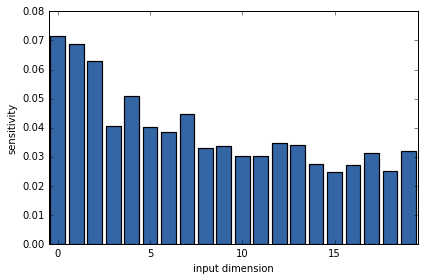

In [8]:
kernel.plot_ARD()

ValueError: total size of new array must be unchanged

 C:\Users\Maxim\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


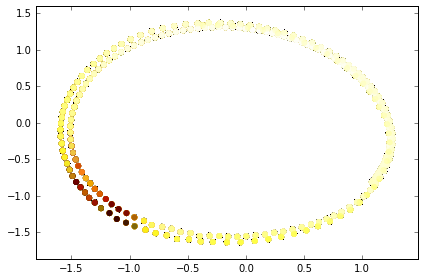

In [8]:
m.plot(visible_dims=(0,1))

Extract latent X from the model:

In [7]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |         1.10122422  |               |        
  [0 1]      |        -0.85360718  |               |        
  [0 2]      |         1.01241548  |               |        
  [0 3]      |        -0.90418774  |               |        
  [0 4]      |         1.09875741  |               |        
  [0 5]      |        -0.60562141  |               |        
  [0 6]      |         0.60565690  |               |        
  [0 7]      |        -1.09013885  |               |        
  [0 8]      |        -0.92187784  |               |        
  [0 9]      |         0.96367597  |               |        
  [ 0 10]    |        -0.83801245  |               |        
  [ 0 11]    |         1.24691403  |               |        
  [ 0 12]    |        -0.61756344  |               |        
  [ 0 13]    |         0.80484985  |               |        
  [ 0 14]    |        -1.07350312  |               |        
  [ 0 15]    |         0

Plot first 5 values to visualize:

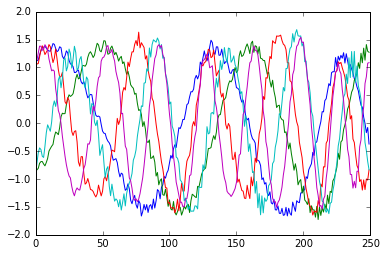

In [8]:
mp.plot(X[:,0:5])

Extract kernel matrix:

In [9]:
print(kernel)

  rbf.         |           value  |  constraints  |  priors
  variance     |  0.341368953427  |      +ve      |        
  lengthscale  |           (50,)  |      +ve      |        


In [10]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 0.34136895  0.3375711   0.32773884 ...,  0.01553658  0.00990779
   0.00875426]
 [ 0.3375711   0.34136895  0.33658213 ...,  0.01541765  0.00987407
   0.00877122]
 [ 0.32773884  0.33658213  0.34136895 ...,  0.01627133  0.01040835
   0.00920039]
 ..., 
 [ 0.01553658  0.01541765  0.01627133 ...,  0.34136895  0.26480534
   0.13106939]
 [ 0.00990779  0.00987407  0.01040835 ...,  0.26480534  0.34136895
   0.2572574 ]
 [ 0.00875426  0.00877122  0.00920039 ...,  0.13106939  0.2572574
   0.34136895]]


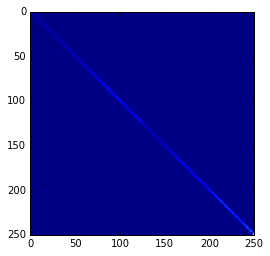

In [14]:
mp.imshow(GPy.kern.Poly(Q).K(X,X))

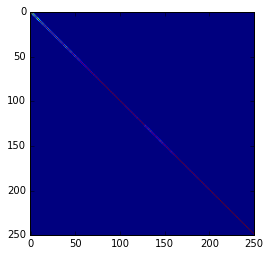

In [23]:
mp.imshow(GPy.kern.

Function to predict new artificial frame using mean prediction method:

In [11]:
def predict_new_latent_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [12]:
N_synt = 500
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_latent_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[-0.53969784  1.14194891 -0.54537871 ...,  1.51080481 -1.3116991
  -0.97438138]
 [-0.63148443  1.25958812 -0.48849422 ...,  1.24260584 -1.00808213
  -0.74013711]
 [-0.70936713  1.39401299 -0.44769977 ...,  1.04815928 -0.75063805
  -0.50703526]
 ..., 
 [ 1.1858776  -0.5000554   1.11218752 ..., -0.64956193  1.31815689
   0.1642715 ]
 [ 1.2166048  -0.34234737  1.03852865 ..., -0.63866398  1.44143272
   1.24890676]
 [ 1.17945794 -0.20062365  1.00001047 ..., -0.49342449  0.66963165
   1.70604555]]


Plot of new X:

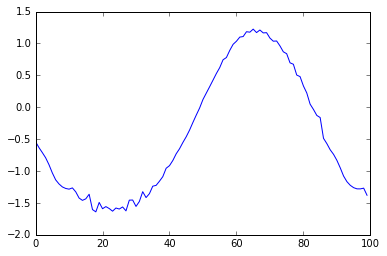

In [13]:
mp.plot(X_synt[0:100,0:1])
#mp.plot(X[:,0:2])

Now perform syntesis of the dinamic texture based on new X by using multivariate Gaussian:

In [14]:
Y_synt = np.zeros((N_synt,D))

Ky = kernel.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample_norm)
k_y = kernel.K(X,X_synt)
k_yy = kernel.K(X_synt,X_synt)

meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))


for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

print(Y_synt)

[[-2.65976994 -2.60149641 -1.9795709  ...,  1.46163402  1.97108858
   2.11865502]
 [-2.68322093 -2.56436461 -1.83114383 ...,  1.71851242  2.29566491
   2.68009327]
 [-2.69556979 -2.47094242 -1.79119309 ...,  1.93390061  2.3831516
   3.08054701]
 ..., 
 [ 0.5333193   0.49418732  0.57620972 ...,  1.13508641  1.17994111
   1.19945101]
 [ 0.54130322  0.50577224  0.5876062  ...,  1.19271574  1.1843276
   1.18357214]
 [ 0.52779934  0.48892386  0.56066748 ...,  1.25569912  1.25558121
   1.1758473 ]]


In [27]:
np.shape(meann)

(10800, 500)

Display first frame:

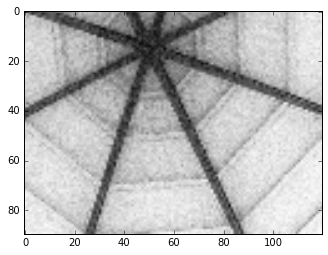

In [15]:
show_frame(Y_synt[0,:])

Denormalization using sample mean and standard deviation:

In [ ]:
Y_synt_denorm = sample_std * Y_synt + sample_mean

Finally, save normalized video. Just to make it more beautiful in visualization perform additional normalization independently for every frame:

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
out = cv2.VideoWriter('data\output.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')